# 이론

기존 AE는 input의 차원축소를 하는 인코더를 학습하기위해 디코더가 붙었다면 VAE는 반대로 latent noise를 디코더를 통과시켜 input 데이터와 유사한 데이터를 생성하는데 초점을 둔다.

latent variable인 $z$ 의 확률분포를 $p_\theta(z)$ 라고 하고 $z$ 가 주어졌을 때 $x$ 의 확률분포를 $p_\theta(x|z)$라고 한다면 $x$ 의 likelihood를 최대화하는 확률분포를 찾는것이 목적이 된다.

즉 $p_\theta(x)$ 를 최대화 시키기로 한다.

이때 $p_\theta(x) = \int p_\theta(z)p_\theta(x|z)dz$를 계산하는 것이 불가능하다.  
때문에 인코더를 $p_\theta(x|z)$를 근사하는 $q_\theta(x|z)$를 구할수 있도록 네트워크를 구성한다.  
그리고 이런 아이디어를 Variational Inference라고 한다.

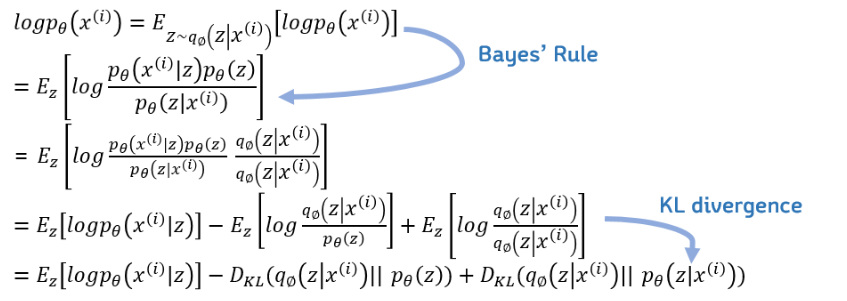

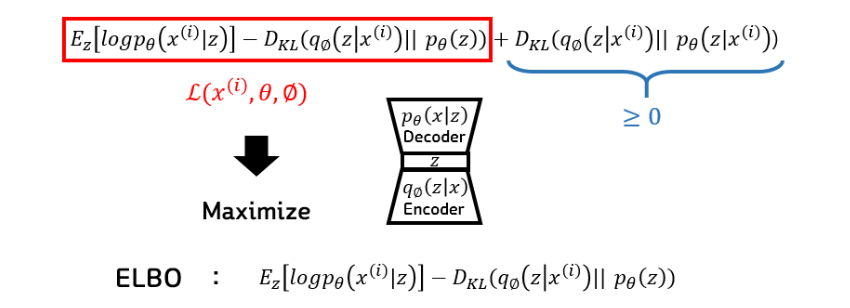

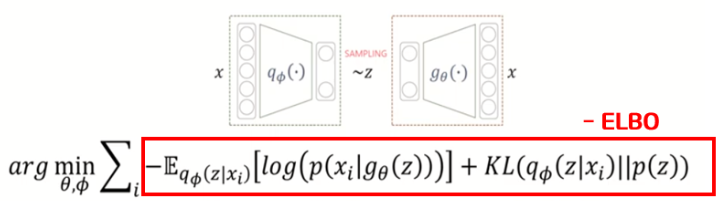

ELBO를 최대화하기 위해 $θ,ϕ$를 추정하는 것 우연하게 AE의 구조를 갖게 됌.  
앞의 항 Reconstruction Error 관점에서 기존 데이터에 대한 likelihood를 최대화한다.  
뒤의 항 Regularization 은 $q_ϕ와 p$를 최대한 같게 만들어 주어야 함.  

먼저 Regularization term을 계산하기위해 두가지 가정을 하자
1. $q_\phi(z|x_i)$ ~ $N(\mu_i,\sigma_i^2I)$
2. $p(z)$ ~ $N(0,1)$

가정 후에 Regularization term은 closed form으로 계산가능 하므로 바로 코드화 가능

Reconstruction Error를 계산하는데는 $q_\phi(z|x_i)$에서 $z$ 를 Sampling 과정이 필요하다. 이때 Sampling 은 Backpropagation 알고리즘이 사용할 수 없어 Reparameterization Trick을 이용한다.  

2/3 47:23

이제 기댓값 계산을 할 때 $p_\theta$ 가 어떤 확률분포를 따르는지 가정을 하는데 이때 가우시안을 가정할 경우 squared error, 베르누이로 가정할 경우 cross entropy식이 나오게 된다.

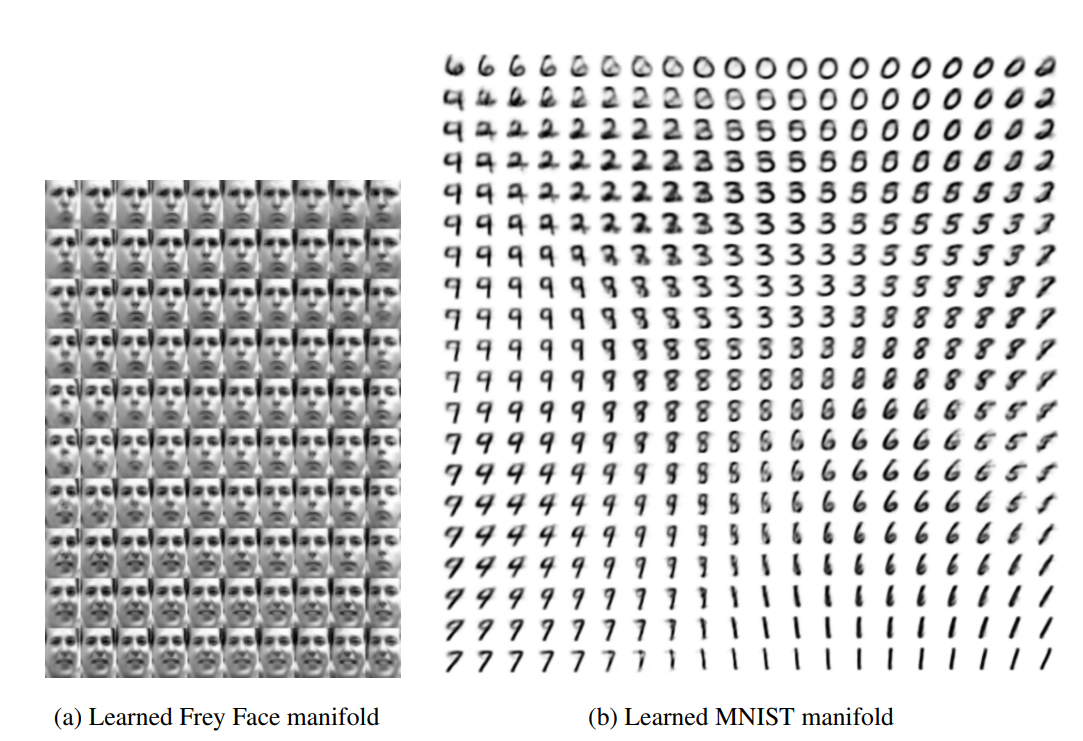

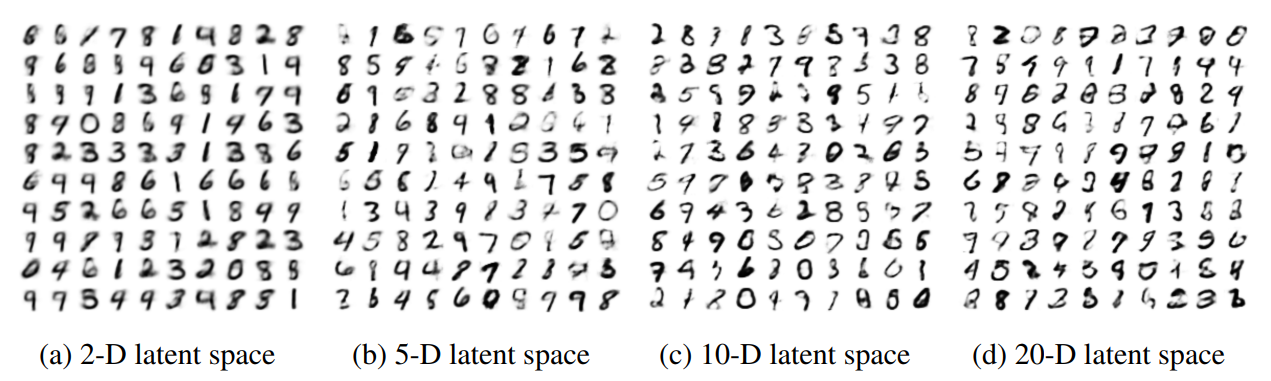

# 유튜브 정리

## Revisit Deep Neural Networks

머신러닝을 한다는 것은 즉 데이터의 추상적인 정보, 특징을 뽑아보고 싶은 것  
모델을 정하고 모델의 파라미터를 찾는 학습과정을 거치는데 Loss가 최소화 되도록 학습시킨다  
학습이 끝나면 최적화된 모델을 이용하여 예측 등의 수행에 사용

backpropagation을 사용하기위한 Loss 함수의 가정이 2개 있다  
1. training sample의 전체 loss는 각 sample의 loss 의 총합과 같다.
2. 모델의 출력값과 target으로만 loss를 구한다.  

## Manifold Learning

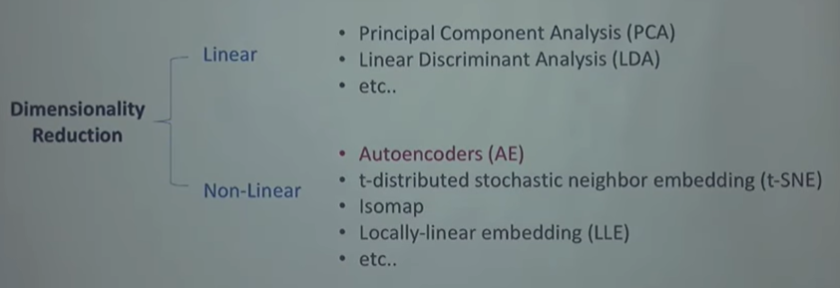

고차원 데이터(trainDB)들을 뿌렸을때 그 샘플들을 잘 아우르는 서브 스페이스(Manifold)가 있을거고 이를 잘 찾아 projection하면 차원축소를 할 수 있을 것  

1. Data compression : 이미지 압축
2. Data visualization :
3. Curse of dimensionality : 데이터의 차원이 증가할수록 해당 공간의 크기가 기하급수적으로 증가하기 때문에 동일한 개수의 데이터의 밀도는 차원이 증가할수록 급속도로 희박해짐, 차원이 증가할수록 샘플데이터의 개수가 많이 필요하다.
데이터가 잘 밀집된 공간(Manifold)를 찾자.
Manifold를 잘 찾으면 샘플링이 잘 될 수 있다.
의미적 거리적으로 중간샘플을 찾고 싶다면 Manifold에서 벗어나지 않게 잘 찾아 중간샘플을 찾아야 함
4. Discovering most important features :
Parzen Windows?

1:21:18

## Autoencoder

입력 X 가 hidden layer를 거쳐 인코딩 된 z를 얻고 이를 다시 hidden layer를 거쳐 디코딩해 x_reconstruct를 얻는다.  

Llnear AE는 hidden layer에 activation이 없이 하나의 transformation을 적용한 것  
Linear AE 의 경우 pca와 똑같은 manifold를 배우는데 basis는 다르다. 논문으로 예전에 나옴  
AE는 예전에 pre-train용으로 많이 사용됐었음  
1. Stacking AE : AE를 쌓아가면서 pre_train 함
2. Denoising AE : input에 noise를 추가하고 AE를 지나 reconst_input에 대하여 error를 구함 일부러 Manifold를 배울때 noise를 추가해서 의미적으로 Manifold를 잘 학습 할 수 있음  
3. Stochastic Contractice AE : noise를 추가해도 매니폴드 공간에서 같은 샘플로 인식할 수 있도록 Regularization 텀을 추가하여 손실을 최소화 시키는 느낌
4. CAE : 3.에서 noise를 빼고 테일러 전개를 이용하여 근사시킴


# 코드 실습

https://aigong.tistory.com/367  
https://di-bigdata-study.tistory.com/5?category=848869  
유튜브에 이활석, 송경우 교수님

In [ ]:
# library

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets,transforms

import time
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Data Load

transform = transforms.Compose([
            transforms.ToTensor()])
dataset_train = datasets.MNIST('./dataset',train=True, transform=transform,download=True)
dataset_test = datasets.MNIST('./dataset',train=False, transform=transform,download=True)
dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=4)
dataloader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# parameter

img_size=28
hidden_dim=400
latent_dim=12

In [ ]:
# class define

def reparameterization(mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

class Encoder(nn.Module):
  def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
      super(Encoder, self).__init__()

      self.model = nn.Sequential(
          nn.Linear(x_dim, h_dim),
          nn.ReLU(),
          nn.Dropout(p=0.2),

          nn.Linear(h_dim, h_dim),
          nn.ReLU(),
          nn.Dropout(p=0.2)
      )

      self.mu = nn.Linear(h_dim, z_dim)
      self.logvar = nn.Linear(h_dim, z_dim)

  def forward(self, x):
      x = self.model(x)

      mu = F.relu(self.mu(x))
      logvar = F.relu(self.logvar(x))

      z = reparameterization(mu, logvar)
      return z, mu, logvar

class Decoder(nn.Module):
  def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
      super(Decoder, self).__init__()

      self.model = nn.Sequential(
          nn.Linear(z_dim, h_dim),
          nn.ReLU(),
          nn.Dropout(p=0.2),

          nn.Linear(h_dim, h_dim),
          nn.ReLU(),
          nn.Dropout(p=0.2),

          nn.Linear(h_dim, x_dim),
          nn.Sigmoid()
      )
  def forward(self, z):
      x_reconst = self.model(z)
      return x_reconst

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# model define

encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()),
                             lr=1e-3, betas=(0.5, 0.999))
n_epochs = 200
train_loss_list=[]
test_loss_list=[]

start_time = time.time()
for epoch in range(n_epochs):

  train_loss = 0
  for i, (x, _) in enumerate(dataloader_train):

    # forward
    x = x.view(-1, img_size**2)
    x = x.to(device)
    z, mu, logvar = encoder(x)
    x_reconst = decoder(z)

    # compute reconstruction loss and KL divergence
    optimizer.zero_grad()

    reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
    kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)
    loss = reconst_loss + kl_div

    loss.backward()
    optimizer.step()

    train_loss += loss.item()


  test_loss = 0
  with torch.no_grad():
    for i, (x, _) in enumerate(dataloader_test):

      # forward
      x = x.view(-1, img_size**2)
      x = x.to(device)
      z, mu, logvar = encoder(x)
      x_reconst = decoder(z)

      # compute reconstruction loss and KL divergence
      reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
      kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

      loss = reconst_loss + kl_div
      test_loss += loss.item()

  train_loss_list.append(train_loss/len(dataloader_train.dataset))
  test_loss_list.append(test_loss/len(dataloader_test.dataset))

  print(f'Epoch: {epoch+1} Average Train Loss: {train_loss/len(dataloader_train.dataset):.2f} Time : {time.time()-start_time:.2f}s')
  print(f'Epoch: {epoch+1} Average Test Loss: {test_loss/len(dataloader_train.dataset):.2f} Time : {time.time()-start_time:.2f}s')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save({
    'Encoder' : encoder.state_dict(),
    'Decoder' : decoder.state_dict(),
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/VAE_Encoder_Decoder_MNIST')

# state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 실습/VAE_Encoder_Decoder_MNIST')

Mounted at /content/drive


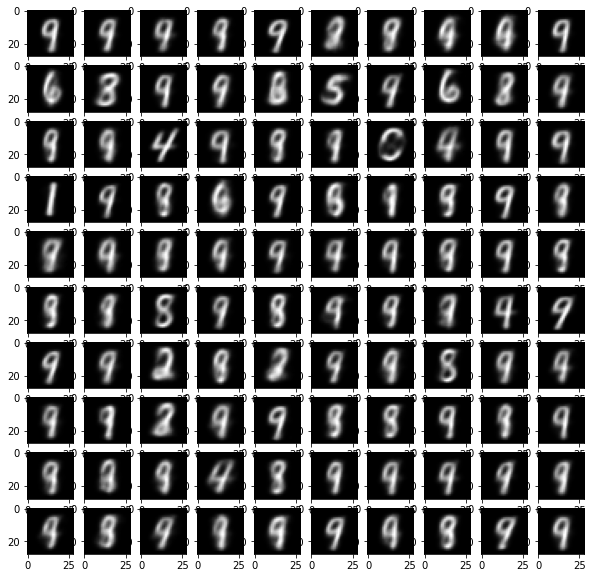

In [ ]:
# image generates

z = torch.randn(100, latent_dim).to(device) # N(0, 1)에서 z 샘플링
sampled_images = decoder(z)
img = sampled_images.view(100,28,28)
rows,cols = 10,10
figure = plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(img[i-1].cpu().detach().numpy().squeeze(), cmap='gray')
plt.show()

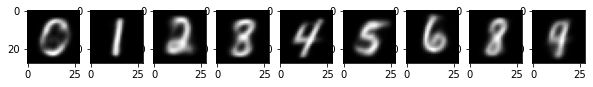

In [ ]:
z_d = torch.concat([z[26],z[30],z[62],z[11],z[22],z[15],z[17],z[18],z[19]],dim=0)
z_d = z_d.view(9,12)
z_d = z_d.to(device)
img_d = decoder(z_d)
img_d = img_d.view(9,28,28)
rows,cols = 1,9
figure = plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(img_d[i-1].cpu().detach().numpy().squeeze(), cmap='gray')
plt.show()

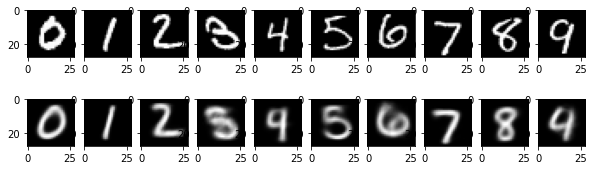

In [ ]:
x = torch.concat([dataloader_test.dataset.__getitem__(i)[0] for i in [3,5,1,18,19,15,11,0,84,16]],dim=0)
x = x.view(10,-1).to(device)
z,m,v = encoder(x)
x_r = decoder(z).view(10,28,28)
x_o = x.view(10,28,28)
imgs = torch.concat([x_o,x_r],dim=0).view(20,28,28)

rows,cols = 2,10
figure = plt.figure(figsize=(10,3))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(imgs[i-1].cpu().detach().numpy().squeeze(), cmap='gray')
plt.show()